# Getting the Cover Image and Secret Message

Secret Message:
Stegosaurus is a genus of thyreophoran dinosaur. Fossils of this genus date
to the Late Jurassic period, where they are found in Kimmeridgian to early
Tithonian aged strata, between 155 and 150 million years ago, in the western
United States and Portugal. ...

Cover Image:


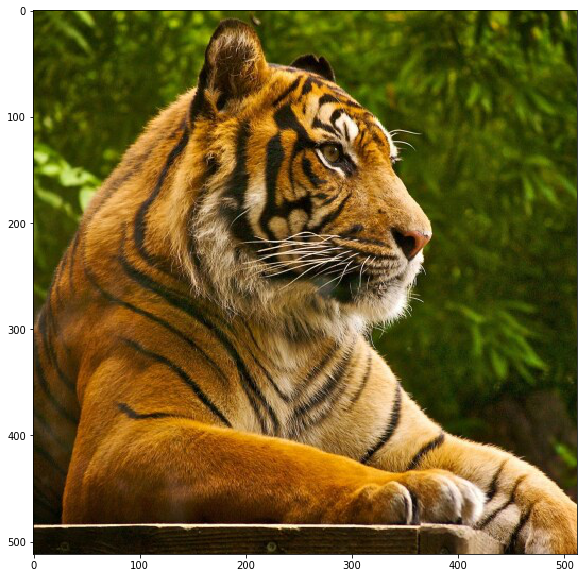

In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

def file_to_string(file='./analysis/text/4.txt'):
    s = ""
    with open(file, 'r') as f:
        for line in f:
            s += line
    return s

def display_img(img):
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

cover_img = cv2.imread('./analysis/img/4.jpg',1)
secret_message = file_to_string()

print("Secret Message:")
print(secret_message[:256]+"...")

print("\nCover Image:")
display_img(cover_img)

# Metrics
We can use the scikit-image measurements in order to get values for MSE, PSNR, and SSIM. Reference: <http://scikit-image.org/docs/dev/api/skimage.measure.html>

In [12]:
import skimage.measure as sk 

def print_metrics(img1, img2):
    print("MSE:",sk.compare_mse(img1, img2))
    print("PSNR:",sk.compare_psnr(img1, img2))
    print("SSIM:",sk.compare_ssim(img1, img2, multichannel=True))

# Message Buffer

In [13]:
class MessageBuffer():
    def __init__(self, message, bits=1):
        if bits != 1 and bits != 2 and bits != 4:
            raise Error("Bits must be 1, 2, or 4. (LSB)")
        self.message = [c for c in message]
        self.bits = bits
        self.mask = ((2**self.bits) - 1)
        self.queue = []
        self.empty = False
    def next_segment(self):
        if not self.queue:
            if not self.message:
                self.empty = True
                return None
            byte = ord(self.message.pop(0))
            segments = []
            for i in range(int(8/self.bits)):
                seg = byte & self.mask
                segments.append(seg)
                byte = byte >> self.bits
            self.queue.extend(segments[::-1])
        return self.queue.pop(0)

buf = MessageBuffer("ABC",2)

# The buffer should output: 1,0,0,1,1,0,0,2,1,0,0,3
expected_values = [1,0,0,1,1,0,0,2,1,0,0,3,None]
exp_idx = 0

# Testing the MessageBuffer class
s = ""
while not buf.empty:
    seg = buf.next_segment()
    s += "{0:d}, ".format(int(seg)) if seg != None else "."
    if seg != expected_values[exp_idx]:
        print("TEST FAILED!!! The message buffer sent {}, but we expected {}".format(seg,expected_values[exp_idx]))
        break
    exp_idx += 1
print("SEGMENTED MESSAGE:",s)

SEGMENTED MESSAGE: 1, 0, 0, 1, 1, 0, 0, 2, 1, 0, 0, 3, .


# Basic LSB Steganography

begin: 25000
end: 0
Metrics of applying a 1-bit LSB steg to the image:
MSE: 0.126021067301
PSNR: 57.1263720743
SSIM: 0.999180503894


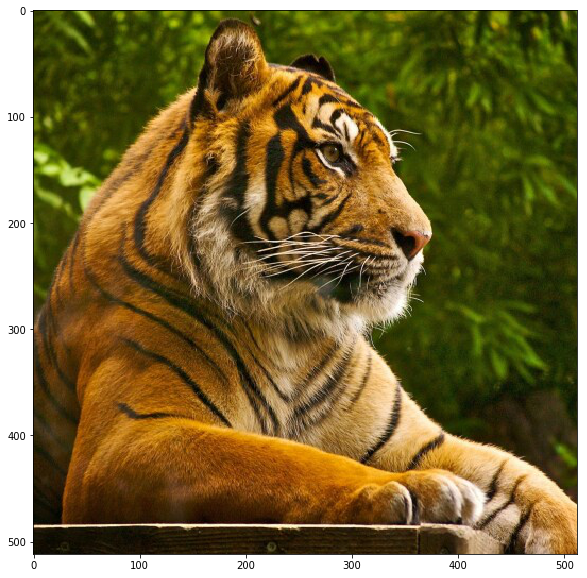

In [14]:
def basic_lsb_steg(img, message, bits=1):
    buf = MessageBuffer(message, bits)
    print("begin:",len(buf.message))
    stego = img.copy()
    it = np.nditer(stego, flags=['multi_index'], op_flags=['writeonly'])
    while not it.finished:
        seg = buf.next_segment()
        if seg == None:
            break
        i = it[0]
        i = ((i >> bits) << bits) | seg
        it[0] = i
        it.iternext()
    print("end:",len(buf.message))
    return stego

stego_img1 = basic_lsb_steg(cover_img, secret_message)
display_img(stego_img1)

print("Metrics of applying a 1-bit LSB steg to the image:")
print_metrics(cover_img, stego_img1)

# LSBM Steganography
iofjeowjfoij

begin: 25000
end: 0
Metrics of applying a 1-bit LSBM steg to the image:
MSE: 0.120909372965
PSNR: 57.3062039194
SSIM: 0.99925636068


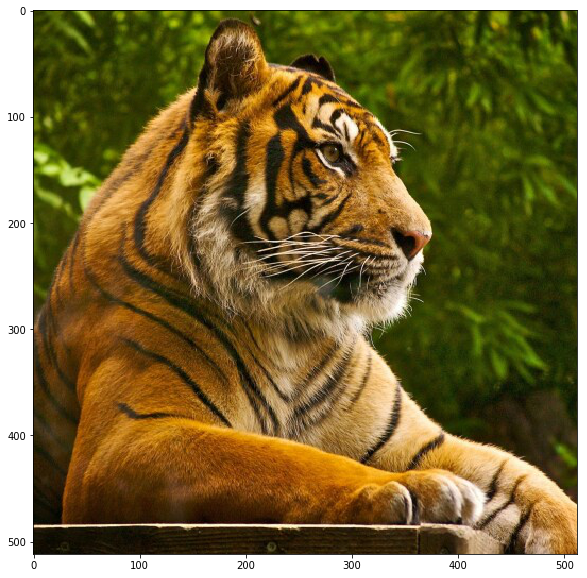

In [15]:
import random as r

def lsbm_steg(img, message):
    def clamp(val, min_, max_):
        if val < min_:
            val = min_
        elif val > max_:
            val = max_
        return val
    
    buf = MessageBuffer(message, 1)
    print("begin:",len(buf.message))
    stego = img.copy()
    it = np.nditer(stego, flags=['multi_index'], op_flags=['writeonly'])
    while not it.finished:
        seg = buf.next_segment()
        if seg == None:
            break
        i = it[0]
        lsb_val = i & buf.mask
        
        if lsb_val != seg:
            i = i + 1 if (r.random() < 0.5) else i - 1
            
            # Make sure that color values are capped
            it[0] = clamp(i, 0, 255)
        it.iternext()
    print("end:",len(buf.message))
    return stego

stego_img2 = lsbm_steg(cover_img, secret_message)
display_img(stego_img2)

print("Metrics of applying a 1-bit LSBM steg to the image:")
print_metrics(cover_img, stego_img2)

# LSBMR Steganography
fiojewoijf

begin: 25000
end: 0
Metrics of applying a 1-bit LSBMR steg to the image:
MSE: 0.0952453613281
PSNR: 58.3423652716
SSIM: 0.999391963541


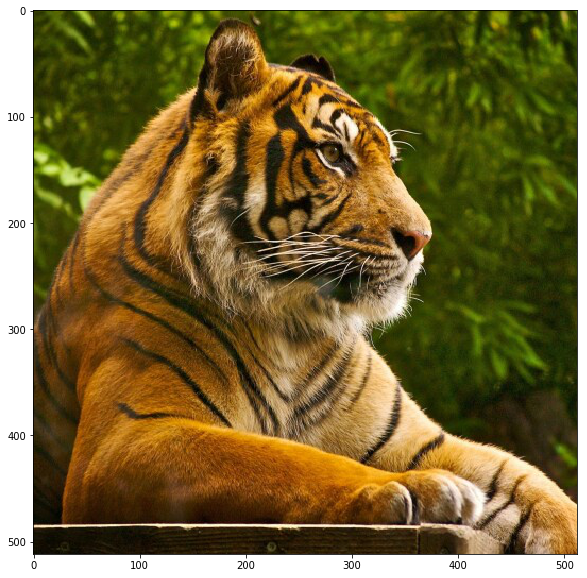

In [16]:
import random as r
import math

def lsbmr_steg(img, message):
    buf = MessageBuffer(message, 1)
    print("begin:",len(buf.message))
    stego = img.copy()
    
    def clamp(val, min_, max_):
        if val < min_:
            val = min_
        elif val > max_:
            val = max_
        return val
    
    def lsb(val):
        return val & buf.mask
    
    def f(x0,x1):
        return lsb(math.floor(x0/2.0) + x1)
    
    it = np.nditer(stego, flags=['multi_index'], op_flags=['readwrite'])
    prev_pixel = None
    
    while not it.finished:
        if it.multi_index[2] != 0:
            it.iternext()
            continue
            
        i = it[0]
            
        if i < (0+2) or i > (255-2):
            it.iternext()
            continue
            
        seg = buf.next_segment()
        if seg == None:
            break
        
       
        
        if not prev_pixel:
            prev_pixel = (i, seg, tuple([it.multi_index[0],it.multi_index[1],it.multi_index[2]]))
        else:
            x0 = prev_pixel[0]
            x1 = i
            m0 = prev_pixel[1]
            m1 = seg
            
            if lsb(x0) == m0:
                if f(x0,x1) != m1:
                    val = 1 if (r.random() < 0.5) else -1
                    x1 = x1+val
                else:
                    x1 = x1
                x0 = x0
            else:
                if f(x0-1,x1) != m1:
                    x0 = x0 + 1
                else:
                    x0 = x0 - 1
                x1 = x1
            
            x0 = clamp(x0, 0, 255)
            x1 = clamp(x1, 0, 255)
            
            x0_loc = prev_pixel[2]
            
            stego[x0_loc[0], x0_loc[1], x0_loc[2]] = x0
            it[0] = x1
            prev_pixel = None
        it.iternext()
    print("end:",len(buf.message))
    return stego

stego_img3 = lsbmr_steg(cover_img, secret_message)
display_img(stego_img3)

print("Metrics of applying a 1-bit LSBMR steg to the image:")
print_metrics(cover_img, stego_img3)

# Proposed Algorithm
foijwiojef

begin: 25000
end: 0
50.577071387855014%
Metrics of applying a 1-bit Proposed Algorithm steg to the image:
MSE: 0.0710703531901
PSNR: 59.6139188716
SSIM: 0.999562303958

EXTRACTED MESSAGE:
 Stegosaurus is a genus of thyreophoran dinosaur. Fossils of this genus date
to the Late Jurassic period, where they are found in Kimmeridgian to early
Tithonian aged strata, between 155 and 150 million years ago, in the western
United States and Portugal. Several species have been classified in the upper
Morrison Formation of the western U.S, though only three are universally
recognized; S. stenops, S. ungulatus and S. sulcatus. The remains of over 80
individual animals of this genus have been found. Stegos...


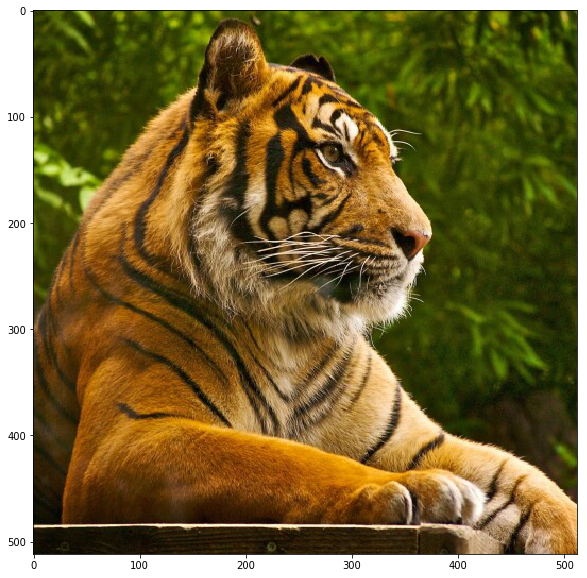

In [17]:
import random as r
import math

def proposed_steg(img, message):
    buf = MessageBuffer(message, 1)
    print("begin:",len(buf.message))
    stego = img.copy()
    
    def clamp(val, min_, max_):
        if val < min_:
            val = val + 2
        elif val > max_:
            val = val - 2
        return val
    
    def lsb(val):
        return val & buf.mask
    
    def lsb_2bits(val):
        return (val & 0b00000110) >> 1
    
    def invert_2bits(val, bits=2):
        val = val & (2**(bits)-1)
        return (2**(bits)-1) - val
    
    def f(x0,x1):
        return lsb(math.floor(x0/2.0) + x1)
    
    it = np.nditer(stego, flags=['multi_index'], op_flags=['readwrite'])
    prev_pixel = None
    
    count = 0.0
    total = 0.0
    
    data_segs = []
    
    while not it.finished:
        total += 1
        if it.multi_index[2] != 0:
            it.iternext()
            
        i = it[0]
        
        if i < (0+2) or i > (255-2):
            it.iternext()
            continue
        
        pos = tuple([it.multi_index[0],it.multi_index[1],it.multi_index[2]])
        
        if not prev_pixel:
            prev_pixel = (i, pos)
        else:
            x0 = prev_pixel[0]
            x0_pos = prev_pixel[1]
            
            x1 = i
            m0 = buf.next_segment()
            if m0 == None:
                break
            m1 = buf.next_segment()
            
            seg_2bit = (2*m0 + m1)
            
            if lsb_2bits(x0) == seg_2bit:
                count += 1
                data_segs.append((1, x0_pos))
                stego[x0_pos[0], x0_pos[1], x0_pos[2]] = ((stego[x0_pos[0], x0_pos[1], x0_pos[2]] >> 1) << 1)
                prev_pixel = (i, pos)
                
            elif lsb_2bits(x1) == seg_2bit:
                count += 1
                data_segs.append((1, pos))
                it[0] = ((it[0] >> 1) << 1)
                
            elif lsb_2bits(x0) == invert_2bits(seg_2bit):
                count += 1
                data_segs.append((1, x0_pos))
                stego[x0_pos[0], x0_pos[1], x0_pos[2]] = ((stego[x0_pos[0], x0_pos[1], x0_pos[2]] >> 1) << 1) | 1
                prev_pixel = (i, pos)
                
            elif lsb_2bits(x1) == invert_2bits(seg_2bit):
                count += 1
                data_segs.append((1, pos))
                it[0] = ((it[0] >> 1) << 1) | 1
            else:
#                 print("SEGS:","{:02b}".format(seg_2bit))
#                 print("X0:","{:01b}".format(lsb(x0)))
#                 print("X1:","{:01b}".format(lsb(x1)))
                if lsb(x0) == m0:
                    if f(x0,x1) != m1:
                        val = 1 if (r.random() < 0.5) else -1
                        x1 = x1+val
                    else:
                        x1 = x1
                    x0 = x0
                else:
                    if f(x0-1,x1) != m1:
                        x0 = x0 + 1
                    else:
                        x0 = x0 - 1
                    x1 = x1
            
                x0 = clamp(x0, 0, 255)
                x1 = clamp(x1, 0, 255)
                
#                 print("m0:","{:01b}".format(lsb(x0)))
#                 print("m1 = f(X0,X1):","{:01b}".format(f(x0,x1)))

                stego[x0_pos[0], x0_pos[1], x0_pos[2]] = x0
                it[0] = x1
                data_segs.append((0,x0_pos,pos))
                prev_pixel = None

        it.iternext()
    print("end:",len(buf.message))
    print("{}%".format((100*count/total)))
    return stego, data_segs

stego_img4, data = proposed_steg(cover_img, secret_message)
display_img(stego_img4)

print("Metrics of applying a 1-bit Proposed Algorithm steg to the image:")
print_metrics(cover_img, stego_img4)

def extract(img, data):
    def lsb(val):
        return val & 0x01
    
    def lsb_2bits(val):
        return (val & 0b00000110) >> 1
    
    def invert_2bits(val, bits=2):
        val = val & (2**(bits)-1)
        return (2**(bits)-1) - val
    
    def f(x0,x1):
        return lsb(math.floor(x0/2.0) + x1)
    
    segs = ''
    words = ''
    
    for d in data:
        if len(segs) >= 8:
            char = chr(int(segs[:8], 2))
            words += char
            segs = segs[8:]
        if d[0] == 0:
            pos = [None for i in range(2)]
            pos[0] = d[1]
            pos[1] = d[2]
            x0 = img[pos[0][0], pos[0][1], pos[0][2]]
            x1 = img[pos[1][0], pos[1][1], pos[1][2]]
            m0 = lsb(x0)
            m1 = f(x0,x1)
            segs += str(m0) + str(m1)
        elif d[0] == 1:
            pos = d[1]
            x = img[pos[0], pos[1], pos[2]]
            invert_bit = lsb(x)
            seg = lsb_2bits(x)
            if invert_bit == 0:
                segs += "{:02b}".format(seg)
            elif invert_bit == 1:
                segs += "{:02b}".format(invert_2bits(seg))
    
    return words
            


print("\nEXTRACTED MESSAGE:\n",extract(stego_img4, data)[:512]+"...")

# Analysis of Proposed Method
Now we will measure the effectiveness of the proposed method. I will embed several messages of varying sizes within 5 different images of the same size, finding the average PSNR and SSIM of each.

In [141]:
images = []
messages = []

# Get images
for i in range(5):
    img = cv2.imread('./analysis/img/'+str(i)+'.jpg',1)
    images.append(img)

# Get messages
for i in range(6):
    m = file_to_string(file='./analysis/text/'+str(i)+'.txt')
    messages.append(m)
    
print("Total number of images:",len(images))
print("Total number of messages:",len(messages))

Total number of images: 5
Total number of messages: 6


wefeawef

In [142]:
from multiprocessing import Pool

pool = Pool(processes=8)

algorithms = {
    "LSB": basic_lsb_steg,
    "LSBM": lsbm_steg,
    "LSBMR": lsbmr_steg,
    "Proposed Algorithm": proposed_steg
}

stats = {}

def perform_analysis(params):
    algo = params[0]
    img = params[1]
    m = params[2]
    steg = algo(img,m)
    steg = steg[0] if type(steg) == tuple else steg
    mse = sk.compare_mse(img, steg)
    psnr = sk.compare_psnr(img, steg)
    ssim = sk.compare_ssim(img, steg, multichannel=True)
    return [mse, psnr, ssim]

for a in algorithms:
    print("Analyzing algorithm:", a)
    stats[a] = []
    count = 0
    for m in messages:
        count += 1
        test_cases = []
        for img in images:
            test_cases.append((algorithms[a], img, m))
        print("\tRunning test for message "+str(count)+"...")
        metrics = pool.map(perform_analysis, test_cases)
        print("\tFinished.")
        avg_vec = tuple([sum(y) / len(y) for y in zip(*metrics)])
        stats[a].append(avg_vec)
        
print(stats)

begin: 5000
begin: 5000
Analyzing algorithm: LSBMR
	Running test for message 1...
begin: 5000
begin: 5000
begin: 5000
end: 0
end: 0
end: 0
end: 0
end: 0
begin: 10000
begin: 10000
begin: 10000
begin: 10000
begin: 10000
	Finished.
	Running test for message 2...
end: 0
end: 0
end: 0
end: 0
end: 0
begin: 15000
begin: 15000
begin: 15000
begin: 15000
begin: 15000
	Finished.
	Running test for message 3...
end: 0
end: 0
end: 0
end: 0
end: 0
begin: 20000
begin: 20000
begin: 20000
begin: 20000
begin: 20000
	Finished.
	Running test for message 4...
end: 0
end: 0
end: 0
end: 0
end: 0
begin: 25000
begin: 25000
begin: 25000
begin: 25000
begin: 25000
	Finished.
	Running test for message 5...
end: 0
end: 0
end: 0
end: 0
end: 0
begin: 30000
begin: 30000
begin: 30000
begin: 30000
begin: 30000
	Finished.
	Running test for message 6...
end: 3649
end: 0
end: 0
end: 0
end: 0
begin: 5000
begin: 5000
begin: 5000
begin: 5000
begin: 5000
	Finished.
Analyzing algorithm: LSB
	Running test for message 1...
end: 0


Now to analyze the data...

In [143]:
import pickle

with open('stats.dict', 'wb') as f:
    pickle.dump(stats, f)

wfefwefwe

In [144]:
with open('stats.dict', 'rb') as handle:
    file_stats = pickle.load(handle)
    print(file_stats)

{'LSBM': [(0.025149281819661456, 64.126831937736583, 0.99977590382252512), (0.050177001953125001, 61.126937671308056, 0.99951436859569964), (0.07531687418619791, 59.362817362487228, 0.99926603236607936), (0.10060272216796876, 58.105686217419859, 0.99903823374873646), (0.12593917846679689, 57.130084978074841, 0.99882004514351441), (0.15105082194010416, 56.34031903139762, 0.99862914728523222)], 'LSB': [(0.025416310628255206, 64.079710623243798, 0.99978454574455355), (0.050680287679036463, 61.082446815084403, 0.99953833670190984), (0.076009877522786456, 59.322122789105762, 0.99930114411509408), (0.10149714152018227, 58.06630168723666, 0.99907640911487727), (0.12701059977213541, 57.092437631729105, 0.99886111064364247), (0.15227635701497394, 56.304503754774416, 0.99867525510963495)], 'Proposed Algorithm': [(0.014426167805989581, 66.539627739366665, 0.99987463647006347), (0.02884267171223958, 63.53102494190076, 0.99972933422683175), (0.043213653564453128, 61.774897983032588, 0.9995923103665

wefwe

LSBM
MSE: (0.025149281819661456, 0.050177001953125001, 0.07531687418619791, 0.10060272216796876, 0.12593917846679689, 0.15105082194010416)
PSNR: (64.126831937736583, 61.126937671308056, 59.362817362487228, 58.105686217419859, 57.130084978074841, 56.34031903139762)
SSIM: (0.99977590382252512, 0.99951436859569964, 0.99926603236607936, 0.99903823374873646, 0.99882004514351441, 0.99862914728523222)
LSB
MSE: (0.025416310628255206, 0.050680287679036463, 0.076009877522786456, 0.10149714152018227, 0.12701059977213541, 0.15227635701497394)
PSNR: (64.079710623243798, 61.082446815084403, 59.322122789105762, 58.06630168723666, 57.092437631729105, 56.304503754774416)
SSIM: (0.99978454574455355, 0.99953833670190984, 0.99930114411509408, 0.99907640911487727, 0.99886111064364247, 0.99867525510963495)
Proposed Algorithm
MSE: (0.014426167805989581, 0.02884267171223958, 0.043213653564453128, 0.057779947916666671, 0.072230021158854157, 0.086611175537109369)
PSNR: (66.539627739366665, 63.53102494190076, 61

/home/thomas/virtualenv/steg/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


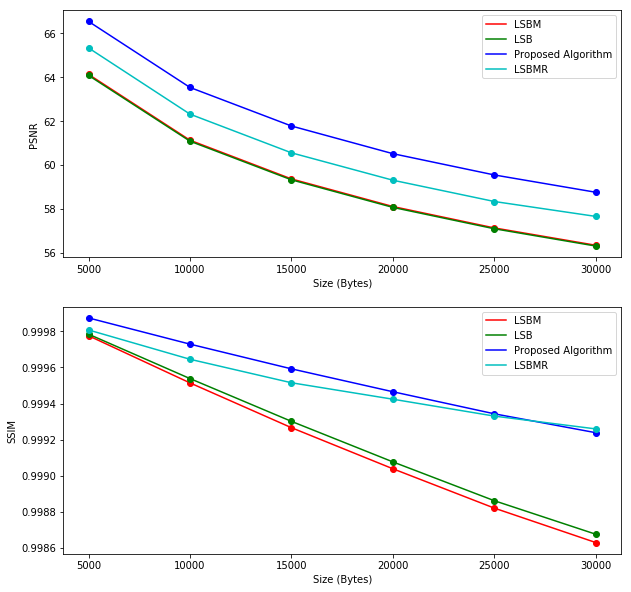

In [145]:
x_axis = [5000,10000,15000,20000,25000,30000]

colors = 'rgbc'

plt.figure(1, figsize=(10,10))

for a in file_stats:
    stat_tuples = file_stats[a]
    mse, psnr, ssim = zip(*stat_tuples)
    print(a)
    print("MSE:",mse)
    print("PSNR:",psnr)
    print("SSIM:",ssim)
    
    c = colors[:1]
    colors = colors[1:]
    
    plt.subplot(211)
    plt.plot(x_axis, psnr, c+"o")
    plt.plot(x_axis, psnr, c, label=a)
    plt.legend()

    plt.subplot(212)
    plt.plot(x_axis, ssim, c+"o")
    plt.plot(x_axis, ssim, c, label=a)
    plt.legend()



plt.subplot(211)
plt.xlabel('Size (Bytes)')
plt.ylabel('PSNR')

plt.subplot(212)
plt.xlabel('Size (Bytes)')
plt.ylabel('SSIM')
plt.show()